In [1]:
from pathlib import Path
import csv
from collections import defaultdict
import os.path
from statistics import mean 
import pandas as pd
import altair as alt


In [2]:
def read_csv(filename):
    with open(filename, newline='') as File:  
        reader = csv.reader(File)
        header1 = next(reader)
        header2 = next(reader)
        results = []
        for row in reader:
            folder = row[0].strip("'")
            parts = Path(folder).parts
            if len(parts) > 2:
                results.append({"product": row[0].strip("'"), "hits": int(row[1]), "bytes": int(row[2]), "cost": float(row[3])})
        return results

In [3]:
k = read_csv("Files_20190417_20190423.csv")

In [3]:
k = read_csv("Files_20190426_20190502.csv")

In [3]:
k = read_csv("Files_20190407_20190506.csv")

In [7]:
k = read_csv("Files_20190506_20190507.csv")

StopIteration: 

In [4]:
len(k)

96452

In [5]:
def split_folder(d):
    result = dict(d)
    result['folder'] = str(Path(d['product']).parent)
    del result['product']
    return result

In [6]:
kk = [split_folder(m) for m in k]

In [7]:
consol = defaultdict(list)

In [8]:
for d in kk:
    consol[d['folder']].append(d)

In [9]:
def product_name(folder):
    parts = Path(folder).parts
    if parts[0] == 'mangrove_cover':
        return parts[0]
    return os.path.join(*parts[:2])


In [10]:
def spatial_id(folder):
    parts = Path(folder).parts
    if len(parts) > 2 and parts[0] == 'L2' and parts[1] == 'sentinel-2-nrt' and parts[-1] == 'NBART':
        try:
            return parts[-2].split("_")[-2][1:]
        except IndexError:
            print(folder)
    else:
        return '<none>'

In [11]:
def bytesto(bytes, to, bsize=1024):
    """convert bytes to megabytes, etc.
       sample code:
           print('mb= ' + str(bytesto(314575262000000, 'm')))
       sample output: 
           mb= 300002347.946
    """

    a = {'k' : 1, 'm': 2, 'g' : 3, 't' : 4, 'p' : 5, 'e' : 6 }
    r = float(bytes)
    for i in range(a[to]):
        r = r / bsize

    return(r)

In [12]:
def merge1(folder, dicts):
    return {
        'hits': max(int(d['hits']) for d in dicts),
        'bytes':sum(int(d['bytes']) for d in dicts),
        'cost': sum(float(d['cost']) for d in dicts),
        'spatial_id': spatial_id(folder),
        'product': product_name(folder)
    }

In [13]:
stage1 = [merge1(key, value) for key, value in consol.items()]

In [14]:
sentinel2 = [d for d in stage1 if d['product'] == 'L2/sentinel-2-nrt']

In [15]:
len(sentinel2)

19736

In [16]:
consol2 = defaultdict(list)

In [17]:
for d in stage1:
    consol2[d['product']].append(d)

In [18]:
def merge2(product, dicts):
    return {
        'hits': sum(int(d['hits']) for d in dicts),
        'bytes': sum(bytesto(int(d['bytes']), 'g') for d in dicts),
        'cost': sum(float(d['cost']) for d in dicts)
    }


In [19]:
x = stage1[0]

In [20]:
x

{'hits': 37457,
 'bytes': 2500757211,
 'cost': 0.2357,
 'spatial_id': '<none>',
 'product': 'projects/WaterBodies'}

In [21]:
stage2 = {key: merge2(key, value) for key, value in consol2.items()}

In [22]:
def get_list(dat):
    av=[]
    for k , v in dat.items():
        m = dict(v)
        m['product'] = k
        av.append(m)
    return av

In [23]:
new_stage = get_list(stage2)

In [24]:
data = pd.DataFrame(new_stage)

In [25]:
data

,bytes,cost,hits,product
0,2.329012,0.2357,37457,projects/WaterBodies
1,3002.607495,26.7321,2941589,L2/sentinel-2-nrt
2,4.661675,0.0576,65016,nidem/v1.0.0
3,1.962165,0.1015,155227,projects/geodata_coast_100k
4,2.017638,0.1208,56623,mangrove_cover
5,122.208005,0.1489,98843,bare-earth/summary
6,19.212200,0.0636,96749,WOfS/filtered_summary
7,2.686901,0.0438,64819,WOfS/annual_summary
8,8.509235,0.0266,40335,WOfS/summary
9,101.793305,0.0986,60907,fractional-cover/fc-percentile


In [26]:
chart = alt.Chart(data)

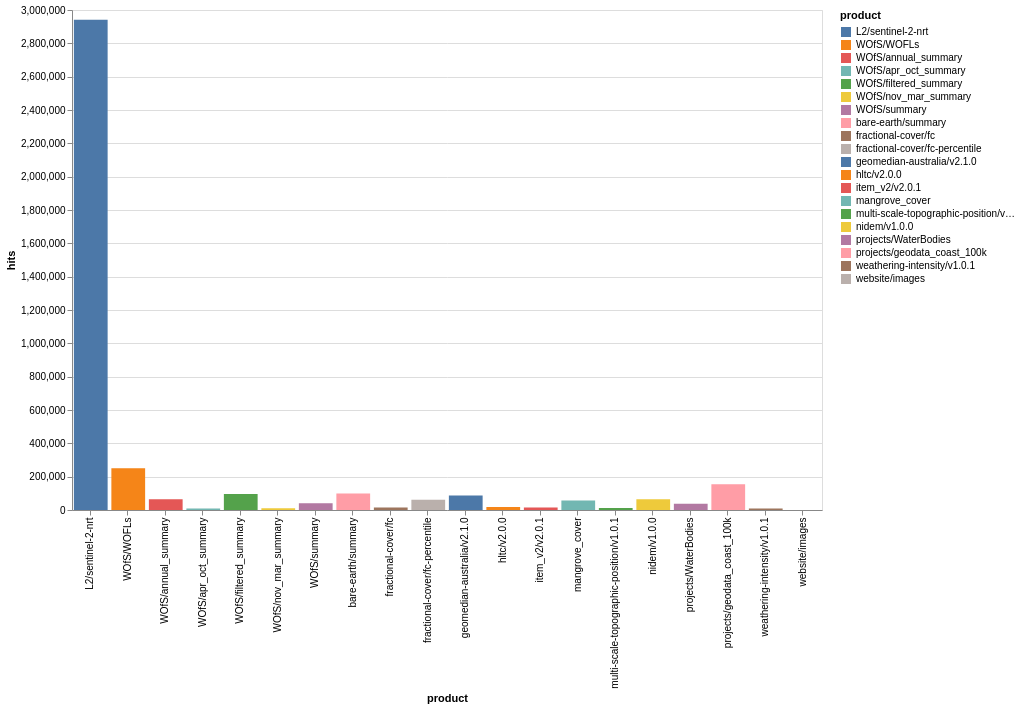

In [27]:
alt.Chart(data).mark_bar().encode(x='product', y='hits', color = 'product:N').properties(
    width=750,
    height=500)

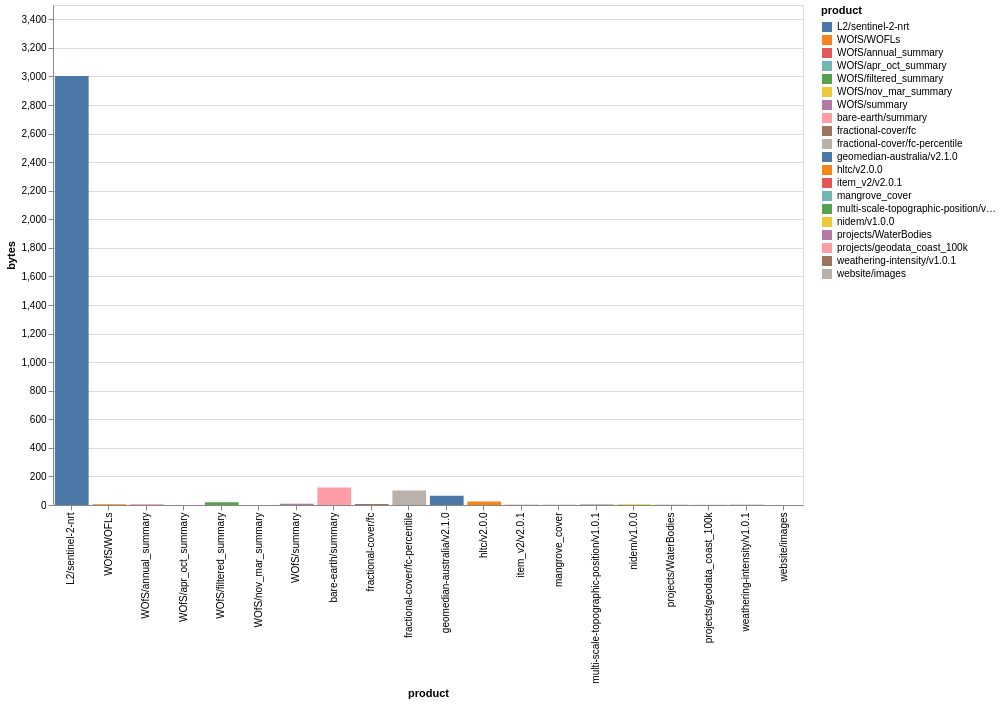

In [28]:
alt.Chart(data).mark_bar().encode(x='product', y='bytes', color = 'product').properties(
    width=750,
    height=500
)

In [1]:
import rasterio
import boto3
from ruamel.yaml import YAML

In [2]:
 s3 = boto3.resource('s3')
bucket = s3.Bucket('dea-public-data')

In [5]:
bucket

s3.Bucket(name='dea-public-data')

In [3]:
bucket_name = "dea-public-data"

In [5]:
def get_s3_url(bucket_name, obj_key):
    return 's3://{bucket_name}/{obj_key}'.format(
        bucket_name=bucket_name, obj_key=obj_key)

In [12]:
key = "L2/sentinel-2-nrt/S2MSIARD/2019-04-15/S2A_OPER_MSI_ARD_TL_SGS__20190415T012404_A019904_T56HLH_N02.07/ARD-METADATA.yaml"

In [13]:
obj = s3.Object(bucket_name, key).get(ResponseCacheControl='no-cache')

In [14]:
raw = obj['Body'].read()

In [20]:
raw_string = raw.decode('utf8')

In [24]:
parser = YAML()

In [26]:
doc = parser.load(raw_string)

In [30]:
doc['extent']['coord']

ordereddict([('ll', ordereddict([('lat', -34.40996085046521), ('lon', 150.8239553990498)])), ('lr', ordereddict([('lat', -34.42538215978734), ('lon', 152.01835521885826)])), ('ul', ordereddict([('lat', -33.42037795466939), ('lon', 150.8489762082609)])), ('ur', ordereddict([('lat', -33.435237691576745), ('lon', 152.02965096464447)]))])

In [18]:
txt_doc = _parse_group(iter(raw_string.split("\n")))

NameError: name '_parse_group' is not defined

In [34]:

list(doc)

['algorithm_information',
 'extent',
 'format',
 'grid_spatial',
 'id',
 'image',
 'instrument',
 'lineage',
 'platform',
 'processing_level',
 'product_type',
 'software_versions',
 'system_information',
 'tile_id']

In [36]:
raw_string.find('provider')

-1

In [37]:
print(raw_string)

algorithm_information:
    algorithm_version: 2.0
    arg25_doi: http://dx.doi.org/10.4225/25/5487CC0D4F40B
    nbar_doi: http://dx.doi.org/10.1109/JSTARS.2010.2042281
    nbar_terrain_corrected_doi: http://dx.doi.org/10.1016/j.rse.2012.06.018
extent:
    center_dt: '2019-04-15T00:06:10.484683Z'
    coord:
        ll:
            lat: -34.40996085046521
            lon: 150.8239553990498
        lr:
            lat: -34.42538215978734
            lon: 152.01835521885826
        ul:
            lat: -33.42037795466939
            lon: 150.8489762082609
        ur:
            lat: -33.435237691576745
            lon: 152.02965096464447
format:
    name: GeoTiff
grid_spatial:
    projection:
        geo_ref_points:
            ll:
                x: 300000
                y: 6190240
            lr:
                x: 409800
                y: 6190240
            ul:
                x: 300000
                y: 6300040
            ur:
                x: 409800
                y: 6300040
 

In [38]:
raw_string.find('56HLH')

2239

In [39]:
raw_string[2200:]

'I_ARD_TL_SGS__20190415T012404_A019904_T56HLH_N02.07_AZIMUTHAL_EXITING.TIF\n        azimuthal_incident:\n            layer: 1\n            path: SUPPLEMENTARY/S2A_OPER_MSI_ARD_TL_SGS__20190415T012404_A019904_T56HLH_N02.07_AZIMUTHAL_INCIDENT.TIF\n        exiting:\n            layer: 1\n            path: SUPPLEMENTARY/S2A_OPER_MSI_ARD_TL_SGS__20190415T012404_A019904_T56HLH_N02.07_EXITING.TIF\n        fmask:\n            layer: 1\n            path: QA/S2A_OPER_MSI_ARD_TL_SGS__20190415T012404_A019904_T56HLH_N02.07_FMASK.TIF\n        incident:\n            layer: 1\n            path: SUPPLEMENTARY/S2A_OPER_MSI_ARD_TL_SGS__20190415T012404_A019904_T56HLH_N02.07_INCIDENT.TIF\n        lambertian_blue:\n            layer: 1\n            path: LAMBERTIAN/LAMBERTIAN_B02.TIF\n        lambertian_coastal_aerosol:\n            layer: 1\n            path: LAMBERTIAN/LAMBERTIAN_B01.TIF\n        lambertian_contiguity:\n            layer: 1\n            path: QA/S2A_OPER_MSI_ARD_TL_SGS__20190415T012404_A0

In [9]:
doc['tile_id'].split('_')[-2][1:]

NameError: name 'doc' is not defined

In [3]:
import fiona

In [4]:
fiona.open("S2A_OPER_GIP_TILPAR_MPC__20151209T095117_V20150622T000000_21000101T000000_B00.kml")

DriverError: unsupported driver: 'LIBKML'

In [1]:
import geopandas

In [2]:
import geopandas as gpd
import fiona
fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support which is disabled by default

gpd.read_file("S2A_OPER_GIP_TILPAR_MPC__20151209T095117_V20150622T000000_21000101T000000_B00.kml")

DriverError: unsupported driver: 'LIBKML'

In [3]:
import pyKM

ModuleNotFoundError: No module named 'pyKML'

In [5]:
grid = fiona.open('australia-mgrs-grid.geojson')

In [7]:
x = next(iter(grid))

In [8]:
x

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('id', '0'),
              ('EASTING', '200000mE'),
              ('NORTHING', '5500000mN'),
              ('100kmSQ_ID', 'KR'),
              ('GZD', '53G'),
              ('MGRS', '53GKR'),
              ('E3', None),
              ('E4', None),
              ('N4', None),
              ('FID_GZD_55', None),
              ('CM', None),
              ('WEST_LONG', None),
              ('SOUTH_LAT', None)]),
 'geometry': {'type': 'Polygon',
  'coordinates': [[(132.63531921298156, -40.62663972682733),
    (132.00000012033843, -40.611873730597075),
    (132.00000011998938, -40.611329009999956),
    (132.00000011998938, -40.60937501999997),
    (132.00000011998935, -40.60742201999994),
    (132.00000011998938, -40.605469019999944),
    (132.00000011998938, -40.60351601999996),
    (132.00000011998938, -40.60156301999997),
    (132.00000011998935, -40.599610019999965),
    (132.00000011998938, -40.59765701999996),
    (132.0000001